In [170]:
import datetime
import itertools
from pprint import pprint

import pandas as pd
import spacepy.pycdf as pycdf
import spacepy.toolbox as tb
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.mlab import griddata

import path
import xarray as xr
from scipy import constants

%matplotlib inline

In [171]:
emass = constants.physical_constants['electron mass energy equivalent in MeV'][0]

def getVelocity(energy, mass):
    """
    energy in eV
    mass in MeV/c**2

    get the veocity of the particle in m/s
    KE = mc**2*(1/gamma -1), gamma = sqrt(1-v**2/c**2)
    Solve this for v gives
    v = c*sqrt(1-(mc**2/E+1)**2)
    """
    energy_ = np.asanyarray(energy)
    gamma = (energy_ / 1e6 + mass) / mass  # keV MeV/c**2 / MeV/c**2
    return constants.c * np.sqrt(1 - (1 / gamma) ** 2)  # m/s

getVelocity(tb.linspace(1e3, 5e3, 10), emass)

array([ 18727896.7064282 ,  22493493.80727271,  25705584.21668509,
        28551618.1700026 ,  31132172.65987082,  33508659.58768355,
        35721849.85294294,  37800455.22890131,  39765603.34721333,
        41633379.63242839])

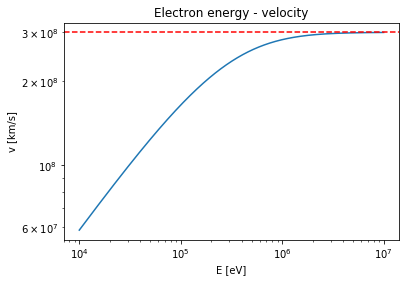

In [172]:
E = tb.logspace(1e4, 10e6, 1000)
plt.loglog(E, getVelocity(E, emass))
plt.xlabel('E [eV]')
plt.ylabel('v [km/s]');
plt.title("Electron energy - velocity")
plt.axhline(constants.physical_constants['speed of light in vacuum'][0], c='r', linestyle='--')

In [173]:
fdir = path.Path('.')
l2files = fdir.files('*L2*.cdf')
l3tagfiles = fdir.files('*tags*.cdf')
pprint((l2files, l3tagfiles))

([Path('./rbspa_rel03_ect-hope-sci-L2_20161210_v5.2.0.cdf'),
  Path('./rbspa_rel03_ect-hope-sci-L2_20161211_v5.2.0.cdf'),
  Path('./rbspa_rel03_ect-hope-sci-L2_20161212_v5.2.0.cdf')],
 [Path('./rbspa_int_ect-hope-PAtags-L3_20161210_v6.0.0.cdf'),
  Path('./rbspa_int_ect-hope-PAtags-L3_20161211_v6.0.0.cdf'),
  Path('./rbspa_int_ect-hope-PAtags-L3_20161212_v6.0.0.cdf')])


# Data prep into interpolated energies

In [174]:
with pycdf.CDF(l2files[1]) as cdf:
    tb.dictree(cdf, verbose=1)

+
|____Acquisition_Period (spacepy.pycdf.Var (7612,))
|____B_Calc_Ele (spacepy.pycdf.Var (4157,))
|____B_Calc_Ion (spacepy.pycdf.Var (3455,))
|____B_Eq_Ele (spacepy.pycdf.Var (4157,))
|____B_Eq_Ion (spacepy.pycdf.Var (3455,))
|____Detector_LABL (spacepy.pycdf.Var (5,))
|____ENERGY_Ele_DELTA (spacepy.pycdf.Var (4157, 72))
|____ENERGY_Ion_DELTA (spacepy.pycdf.Var (3455, 72))
|____ESA_Polarity (spacepy.pycdf.Var (7612,))
|____ESA_Sweep (spacepy.pycdf.Var (7612,))
|____ESA_Volt (spacepy.pycdf.Var (7612, 72))
|____ESA_Volt_LABL_1 (spacepy.pycdf.Var (72,))
|____Energy_Collapsed (spacepy.pycdf.Var (7612,))
|____Energy_LABL (spacepy.pycdf.Var (72,))
|____Epoch (spacepy.pycdf.Var (7612,))
|____Epoch_Ele (spacepy.pycdf.Var (4157,))
|____Epoch_Ele_DELTA (spacepy.pycdf.Var (4157,))
|____Epoch_Ion (spacepy.pycdf.Var (3455,))
|____Epoch_Ion_DELTA (spacepy.pycdf.Var (3455,))
|____FEDU (spacepy.pycdf.Var (4157, 5, 16, 72))
|____FHEDU (spacepy.pycdf.Var (3455, 5, 16, 72))
|____FLAGS (spacepy.pycdf.Var 

## Start with just the apogee mode data and make the plot here



In [175]:
with pycdf.CDF(l2files[1]) as cdf:
    HOPE_ENERGY_Ion = cdf['HOPE_ENERGY_Ion'][...]
    Epoch_Ion = cdf['Epoch_Ion'][...]
    unique_ionE = np.unique(HOPE_ENERGY_Ion[:,0])
    FPDU = cdf['FPDU'][...]
    FHEDU = cdf['FHEDU'][...]
    FODU = cdf['FODU'][...]
    L_Ion = cdf['L_Ion'][...]
    MLT_Ion = cdf['MLT_Ion'][...]
print(unique_ionE)
apogee_inds = HOPE_ENERGY_Ion[:,0] == unique_ionE.min()

[  0.9849      24.97424889]


In [176]:
fpdu_ap = xr.DataArray(FPDU[apogee_inds,...], 
                       dims={'Epoch':pd.DatetimeIndex(Epoch_Ion[apogee_inds]), 
                             'Pixel':np.arange(1,6), 
                             'Sector':np.arange(16), 
                             'Energy':HOPE_ENERGY_Ion[apogee_inds][0,...]})
fhedu_ap = xr.DataArray(FHEDU[apogee_inds,...], 
                       dims={'Epoch':pd.DatetimeIndex(Epoch_Ion[apogee_inds]), 
                             'Pixel':np.arange(1,6), 
                             'Sector':np.arange(16), 
                             'Energy':HOPE_ENERGY_Ion[apogee_inds][0,...]})
fodu_ap = xr.DataArray(FODU[apogee_inds,...], 
                       dims={'Epoch':pd.DatetimeIndex(Epoch_Ion[apogee_inds]), 
                             'Pixel':np.arange(1,6), 
                             'Sector':np.arange(16), 
                             'Energy':HOPE_ENERGY_Ion[apogee_inds][0,...]})


fpdu_pe = xr.DataArray(FPDU[~apogee_inds,...], 
                       dims={'Epoch':pd.DatetimeIndex(Epoch_Ion[~apogee_inds]), 
                             'Pixel':np.arange(1,6), 
                             'Sector':np.arange(16), 
                             'Energy':HOPE_ENERGY_Ion[~apogee_inds][0,...]})

L = pd.DataFrame({'L':L_Ion[apogee_inds], 
                 'MLT':MLT_Ion[apogee_inds]}, index=pd.DatetimeIndex(Epoch_Ion[apogee_inds]))
L = L.resample(datetime.timedelta(minutes=5)).mean()

In [177]:
fpdu_ap = fpdu_ap.set_index('Epoch')

## OK fine, give up on xarray and go to pandas

In [178]:
FPDU2 = FPDU[apogee_inds]
HOPE_ENERGY_Ion2 = HOPE_ENERGY_Ion[apogee_inds][0]
FPDU2.shape, HOPE_ENERGY_Ion2.shape

((3243, 5, 16, 72), (72,))

In [179]:
{'Epoch':pd.DatetimeIndex(Epoch_Ion[apogee_inds])}

{'Epoch': DatetimeIndex(['2016-12-11 00:00:08.292000', '2016-12-11 00:00:30.989000',
                '2016-12-11 00:00:53.685000', '2016-12-11 00:01:16.381000',
                '2016-12-11 00:01:39.078000', '2016-12-11 00:02:01.775000',
                '2016-12-11 00:02:24.472000', '2016-12-11 00:02:47.168000',
                '2016-12-11 00:03:09.865000', '2016-12-11 00:03:32.561000',
                ...
                '2016-12-11 23:46:03.116000', '2016-12-11 23:46:25.813000',
                '2016-12-11 23:46:48.510000', '2016-12-11 23:47:11.207000',
                '2016-12-11 23:47:56.599000', '2016-12-11 23:48:19.296000',
                '2016-12-11 23:48:41.993000', '2016-12-11 23:49:04.689000',
                '2016-12-11 23:49:27.386000', '2016-12-11 23:49:50.083000'],
               dtype='datetime64[ns]', length=3243, freq=None)}

In [180]:
fpdu_df = pd.DataFrame({'pixel':1, 
                        'sector':0, 
                        'energy':HOPE_ENERGY_Ion[apogee_inds][:,0], 
                       'FPDU':FPDU2[:,0,0,0]}, 
                    index=pd.DatetimeIndex(Epoch_Ion[apogee_inds]))

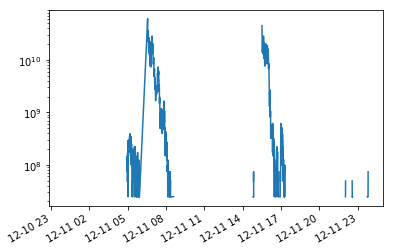

In [181]:
fpdu_df['FPDU'].plot(logy=True)

### Loop over all the pixles, sectors, and energies to make the DF

In [182]:
s=e=0
p=1
fpdu_df = pd.DataFrame({'pixel':p, 
                        'sector':s, 
                        'energy':HOPE_ENERGY_Ion[apogee_inds][:,e], 
                       'FPDU':FPDU2[:,p-1,s,e], 
                    'Epoch':pd.DatetimeIndex(Epoch_Ion[apogee_inds])})


In [183]:
fpdu_df.shape

(3243, 5)

In [184]:
with pycdf.CDF(l3tagfiles[1]) as cdf:
    tb.dictree(cdf, verbose=1)
    PA_Ion = cdf['PA_Ion'][...]
    PHI_Ion = cdf['PHI_Ion'][...]
PA_Ion2 = PA_Ion[apogee_inds]
PHI_Ion2 = PHI_Ion[apogee_inds]

+
|____ESA_Volt_Elc_Cntr_e (spacepy.pycdf.Var (4157, 72))
|____ESA_Volt_Ion_Cntr_H (spacepy.pycdf.Var (3455, 72))
|____Epoch_Ele (spacepy.pycdf.Var (4157,))
|____Epoch_Ion (spacepy.pycdf.Var (3455,))
|____HOPE_DETECTOR (spacepy.pycdf.Var (5,))
|____HOPE_SECTOR (spacepy.pycdf.Var (16,))
|____PA_Ele (spacepy.pycdf.Var (4157, 5, 16, 72))
|____PA_Ion (spacepy.pycdf.Var (3455, 5, 16, 72))
|____PHI_Ele (spacepy.pycdf.Var (4157, 5, 16, 72))
|____PHI_Ion (spacepy.pycdf.Var (3455, 5, 16, 72))


In [185]:
np.sin(np.deg2rad(0))

0.0

In [186]:
def get_vperp_vpar(eind, PA):
    # total velocity
    V = getVelocity(HOPE_ENERGY_Ion2[eind], emass)
    vperp = V*np.sin(np.deg2rad(PA))
    vpar =  V*np.cos(np.deg2rad(PA))
    return vperp, vpar, V


def calc_psd(eind, flux, vel):
    fv = 2.0*HOPE_ENERGY_Ion2[eind]*flux/vel**4
    return fv
    
        
        
s=e=0
p=1

Vperp, Vpar, V = get_vperp_vpar(e, PA_Ion2[:,p-1,s,e])
dfs = [pd.DataFrame({'pixel':p, 
                        'sector':s, 
                        'energy':e, #'energy':HOPE_ENERGY_Ion[apogee_inds][:,e], 
                       'FPDU':FPDU2[:,p-1,s,e], 
                    'Epoch':pd.DatetimeIndex(Epoch_Ion[apogee_inds]), 
                        'PA_Ion':PA_Ion2[:,p-1,s,e], 
                   'PHI_Ion':PHI_Ion2[:,p-1,s,e], 
                    'Vperp':Vperp, 
                     'Vpar':Vpar, 
                     'PSD':calc_psd(e, FPDU2[:,p-1,s,e], V),
                    })]

dfs = dfs*5*16*72
for ii, (p, s, e) in tqdm.tqdm(enumerate(itertools.product(np.arange(1,6), 
                                                           np.arange(16), 
                                                           np.arange(72))), 
                               total=5*16*72):
    if ii == 0:
        continue
    Vperp, Vpar, V = get_vperp_vpar(e, PA_Ion2[:,p-1,s,e])
    dfs[ii] = pd.DataFrame({'pixel':p, 
                            'sector':s, 
                            'energy':e, #'energy':HOPE_ENERGY_Ion[apogee_inds][:,e], 
                           'FPDU':FPDU2[:,p-1,s,e], 
                        'Epoch':pd.DatetimeIndex(Epoch_Ion[apogee_inds]), 
                           'PA_Ion':PA_Ion2[:,p-1,s,e], 
                           'PHI_Ion':PHI_Ion2[:,p-1,s,e], 
                            'Vperp':Vperp, 
                             'Vpar':Vpar, 
                             'PSD':calc_psd(e, FPDU2[:,p-1,s,e], V),
                           })
fpdu_df = pd.concat(dfs)
del dfs
    
    

100%|██████████| 5760/5760 [00:32<00:00, 176.74it/s]


In [187]:
fpdu_df.head()

,Epoch,FPDU,PA_Ion,PHI_Ion,PSD,Vpar,Vperp,energy,pixel,sector
0,2016-12-11 00:00:08.292,0.0,40,284,0.0,450935.18750,378509.65625,0,1,0
1,2016-12-11 00:00:30.989,0.0,36,267,0.0,476226.65625,346033.12500,0,1,0
2,2016-12-11 00:00:53.685,0.0,42,252,0.0,437427.25000,393742.00000,0,1,0
3,2016-12-11 00:01:16.381,0.0,52,247,0.0,362415.09375,463868.31250,0,1,0
4,2016-12-11 00:01:39.078,0.0,63,252,0.0,267141.03125,524510.31250,0,1,0


In [188]:
fpdu_df = fpdu_df.set_index('Epoch')
fpdu_df.head()

,FPDU,PA_Ion,PHI_Ion,PSD,Vpar,Vperp,energy,pixel,sector
Epoch,,,,,,,,,
2016-12-11 00:00:08.292,0.0,40,284,0.0,450935.18750,378509.65625,0,1,0
2016-12-11 00:00:30.989,0.0,36,267,0.0,476226.65625,346033.12500,0,1,0
2016-12-11 00:00:53.685,0.0,42,252,0.0,437427.25000,393742.00000,0,1,0
2016-12-11 00:01:16.381,0.0,52,247,0.0,362415.09375,463868.31250,0,1,0
2016-12-11 00:01:39.078,0.0,63,252,0.0,267141.03125,524510.31250,0,1,0


In [189]:
fpdu_df.loc['2016-12-11T17:10:00':'2016-12-11T17:20:00'].shape


(132480, 9)

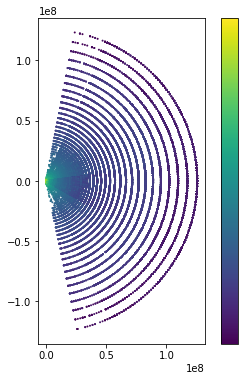

In [190]:
tmp = fpdu_df.loc['2016-12-11T17:10:00':'2016-12-11T17:20:00']

plt.figure(figsize=(6,6))
plt.scatter(tmp['Vperp'], tmp['Vpar'], s=4, c=tmp['PSD'], norm=LogNorm(), 
           edgecolors='none')
plt.gca().set_aspect('equal')
plt.colorbar()

/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


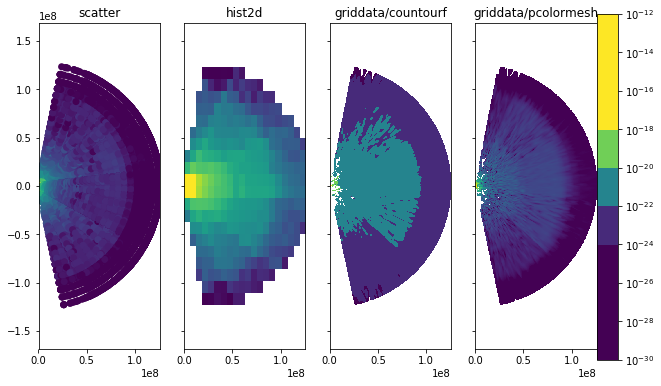

In [192]:
tmp = fpdu_df.loc['2016-12-11T17:10:00':'2016-12-11T17:20:00']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6), sharex=True, sharey=True)
ax[0].scatter(tmp['Vperp'], tmp['Vpar'], s=50, c=tmp['PSD'], norm=LogNorm(), 
           edgecolors='none', vmin=1e-23, vmax=1e-17)
ax[0].set_aspect('equal')
ax[0].set_title('scatter')

nbins = 20
ax[1].hist2d(tmp['Vperp'], tmp['Vpar'], bins=(nbins, nbins), 
             weights=tmp['PSD'], norm=LogNorm(), vmin=1e-23, vmax=1e-17)
ax[1].set_aspect('equal')
ax[1].set_title('hist2d')

# define grid.
xi = np.linspace(-1.5e8, 1.5e8, 1000)
yi = np.linspace(-1.5e8, 1.5e8, 1000)
zi = griddata(tmp['Vperp'], tmp['Vpar'], tmp['PSD'], xi, yi, interp='linear')
CS = ax[2].contourf(xi, yi, zi, 10, norm=LogNorm(), vmin=1e-23, vmax=1e-17)

ax[2].set_aspect('equal')
ax[2].set_title('griddata/countourf')

ax[3].pcolormesh(xi, yi, zi, norm=LogNorm(), vmin=1e-23, vmax=1e-17)

# ax[3].set_xlim((-1.5e8, 1.5e8))
ax[3].set_aspect('equal')
ax[3].set_title('griddata/pcolormesh')

cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
fig.colorbar(CS, cax=cax)

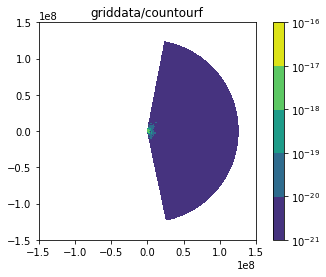

In [198]:
# define grid.
xi = np.linspace(-1.5e8, 1.5e8, 1000)
yi = np.linspace(-1.5e8, 1.5e8, 1000)
zi = griddata(tmp['Vperp'], tmp['Vpar'], tmp['PSD'], xi, yi, interp='linear')
zi = np.clip(zi, 1e-20, 1e-17)
CS = plt.contourf(xi, yi, zi, 10, norm=LogNorm())
plt.gca().set_aspect('equal')
plt.title('griddata/countourf')
plt.colorbar()


In [196]:
plt.contourf?


In [ ]:
fpdu_df.head()

In [ ]:
fpdu_df2 = fpdu_df.set_index(['Epoch', 'energy', 'pixel', 'sector'])
# fpdu_df.resample(datetime.timedelta(minutes=10)).agg({'FPDU':np.mean, 
#                                                      'energy':'first', 
#                                                      'pixel'})
fpdu_df2.head()

In [ ]:
# fpdu_df2.resample(datetime.timedelta(minutes=10)).mean().head()

In [ ]:
fpdu_df2.head()

In [ ]:
fpdu_df2.iloc[0:7000].unstack().resample(datetime.timedelta(minutes=10), level=0).mean().head()


In [ ]:
# fpdu_df2.iloc[0:1000].resample(datetime.timedelta(minutes=10), axis=0).mean()
fpdu_df2.iloc[0:7000].groupby(pd.Grouper(freq=datetime.timedelta(minutes=10), 
                                         level=0)).mean()


In [ ]:
fpdu_df.head()

In [ ]:
np.unique(fpdu_df['sector'])

In [ ]:
fpdu_df3 = fpdu_df.set_index('Epoch')


In [ ]:
fpdu_df3.iloc[:7000]['FPDU'].loc[(fpdu_df3.iloc[:7000]['pixel']==1) & 
                                 (fpdu_df3.iloc[:7000]['sector']==0) &
                                (fpdu_df3.iloc[:7000]['energy']==0)].resample(datetime.timedelta(minutes=10)).mean()